In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MultiLabelBinarizer

from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

## Data Preprocessing

In [2]:
df = pd.read_csv('secondary_data.csv',sep=';', on_bad_lines='skip')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [4]:
# Keep naming consistent
df = df.rename(columns={"Cap-surface": "cap-surface"})

In [5]:
# Because of multicolinearity and name has no correlation
df = df.drop(columns=['spore-print-color',
                     'has-ring'])

#Binary Encoding
binary_mapping = {'[t]': 1, '[f]': 0}
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].map(binary_mapping)
binary_mapping = {'p': 1, 'e': 0}
df['class'] = df['class'].map(binary_mapping)

In [6]:
# Too many Nan values where imputation is not good to do
df = df.drop(columns=['stem-root', 'stem-surface', 'veil-type', 'veil-color'])

In [7]:
df['gill-attachment'].fillna('[?]', inplace=True)
df['ring-type'].fillna('[?]', inplace=True)
df['cap-surface'].fillna('[?]', inplace=True)
df['gill-spacing'].fillna('[?]', inplace=True)
# As per the ? key used, we simply filled in the Nans as they are essentially unknown

In [8]:
columns_to_apply_multilabeling = ['cap-shape','cap-surface','cap-color','gill-attachment', 'gill-spacing', 'gill-color','stem-color','ring-type','season']

for col in columns_to_apply_multilabeling:
    mlb = MultiLabelBinarizer()
    column = df[col].apply(lambda x: x.strip('[]').split(', '))
    
    encoded_data = mlb.fit_transform(column)
    encoded_df = pd.DataFrame(encoded_data, columns=mlb.classes_+"_"+col)
    df = df.drop(col, axis=1)
    df = pd.concat([df, encoded_df], axis=1)

In [9]:
df.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,habitat,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,...,g_ring-type,l_ring-type,m_ring-type,p_ring-type,r_ring-type,z_ring-type,a_season,s_season,u_season,w_season
0,1,15.26,NaN,16.95,17.09,d,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,16.60,NaN,17.99,18.19,d,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,14.07,NaN,17.80,17.74,d,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,14.17,NaN,15.77,15.98,d,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
4,1,14.64,NaN,16.53,17.20,d,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [10]:
X = df.drop(columns = {'habitat','cap-diameter','stem-height','stem-width'})

##drop all columns with NAN
X = X.dropna(axis=1)

In [11]:
y = df['habitat']

In [12]:
#Feature Selection using Chi-Squared Test and SelectKBest
selector = SelectKBest(score_func=chi2, k=10)  # Specify the desired number of features
X_selected = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_feature_indices]
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)

In [13]:
X_selected_df.head(15)

,b_cap-shape,p_cap-shape,i_cap-surface,w_cap-color,e_gill-attachment,f_gill-color,k_gill-color,e_ring-type,l_ring-type,r_ring-type
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0


In [14]:
#Encoding y
mlb = MultiLabelBinarizer()
y_transformed = mlb.fit_transform(y)

In [15]:
X = df
X = X.drop(columns = {'habitat'})

In [16]:
X.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,p_cap-shape,...,g_ring-type,l_ring-type,m_ring-type,p_ring-type,r_ring-type,z_ring-type,a_season,s_season,u_season,w_season
0,1,15.26,NaN,16.95,17.09,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,16.60,NaN,17.99,18.19,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,14.07,NaN,17.80,17.74,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,1,14.17,NaN,15.77,15.98,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1,14.64,NaN,16.53,17.20,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [17]:
#Feature importance Using RandomForests
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)
feature_importances = rf_classifier.feature_importances_
feature_importances_with_names = list(zip(X.columns, feature_importances))
for name, importance in feature_importances_with_names:
    print(f"Feature: {name}, Importance: {importance}")

Feature: class, Importance: 0.01773666197547575
Feature: cap-diameter, Importance: 0.15394044164777082
Feature: does-bruise-or-bleed, Importance: 0.0
Feature: stem-height, Importance: 0.1392795579457498
Feature: stem-width, Importance: 0.1751598365795817
Feature: b_cap-shape, Importance: 0.011210306560828909
Feature: c_cap-shape, Importance: 0.0034973497164792634
Feature: f_cap-shape, Importance: 0.007579991564107267
Feature: o_cap-shape, Importance: 0.0040644403375258336
Feature: p_cap-shape, Importance: 0.006692299369239367
Feature: s_cap-shape, Importance: 0.005046796643157354
Feature: x_cap-shape, Importance: 0.011315075633598367
Feature: ?_cap-surface, Importance: 0.01409593916529091
Feature: d_cap-surface, Importance: 0.0065631599031737075
Feature: e_cap-surface, Importance: 0.002362733439292406
Feature: g_cap-surface, Importance: 0.00917545765291202
Feature: h_cap-surface, Importance: 0.0038664438605961636
Feature: i_cap-surface, Importance: 0.0074314478518998995
Feature: k_cap-

In [18]:
#Top 10 important features
for i, (name, importance) in enumerate(feature_importances_with_names[:10], start=1):
    print(f"{i}. Feature: {name}, Importance: {importance}")

1. Feature: class, Importance: 0.01773666197547575
2. Feature: cap-diameter, Importance: 0.15394044164777082
3. Feature: does-bruise-or-bleed, Importance: 0.0
4. Feature: stem-height, Importance: 0.1392795579457498
5. Feature: stem-width, Importance: 0.1751598365795817
6. Feature: b_cap-shape, Importance: 0.011210306560828909
7. Feature: c_cap-shape, Importance: 0.0034973497164792634
8. Feature: f_cap-shape, Importance: 0.007579991564107267
9. Feature: o_cap-shape, Importance: 0.0040644403375258336
10. Feature: p_cap-shape, Importance: 0.006692299369239367


## Data Visualizations

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
feats_to_use = ['class', 'cap-diameter', 'stem-height', 'stem-width', 
                'b_cap-shape', 'c_cap-shape', 'f_cap-shape', 'o_cap-shape', 'p_cap-shape']

In [30]:
vis_df = pd.concat([X[feats_to_use], y], axis=1)

In [31]:
vis_df

,class,cap-diameter,stem-height,stem-width,b_cap-shape,c_cap-shape,f_cap-shape,o_cap-shape,p_cap-shape,habitat
0,1,15.26,16.95,17.09,0,0,0,0,0,d
1,1,16.60,17.99,18.19,0,0,0,0,0,d
2,1,14.07,17.80,17.74,0,0,0,0,0,d
3,1,14.17,15.77,15.98,0,0,1,0,0,d
4,1,14.64,16.53,17.20,0,0,0,0,0,d
...,...,...,...,...,...,...,...,...,...,...
61064,1,1.18,3.93,6.22,0,0,0,0,0,d
61065,1,1.27,3.18,5.43,0,0,1,0,0,d
61066,1,1.27,3.86,6.37,0,0,0,0,0,d
61067,1,1.24,3.56,5.44,0,0,1,0,0,d


In [32]:
vals = vis_df['habitat'].value_counts()

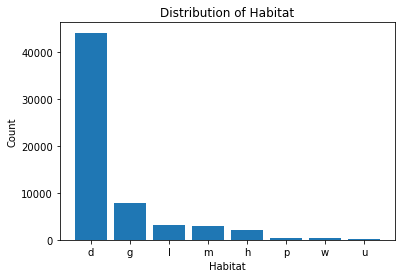

In [33]:
##distribution of the output class coutns
plt.bar(x=vals.index, height=vals)

plt.xlabel('Habitat')
plt.ylabel('Count')
plt.title('Distribution of Habitat')

plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


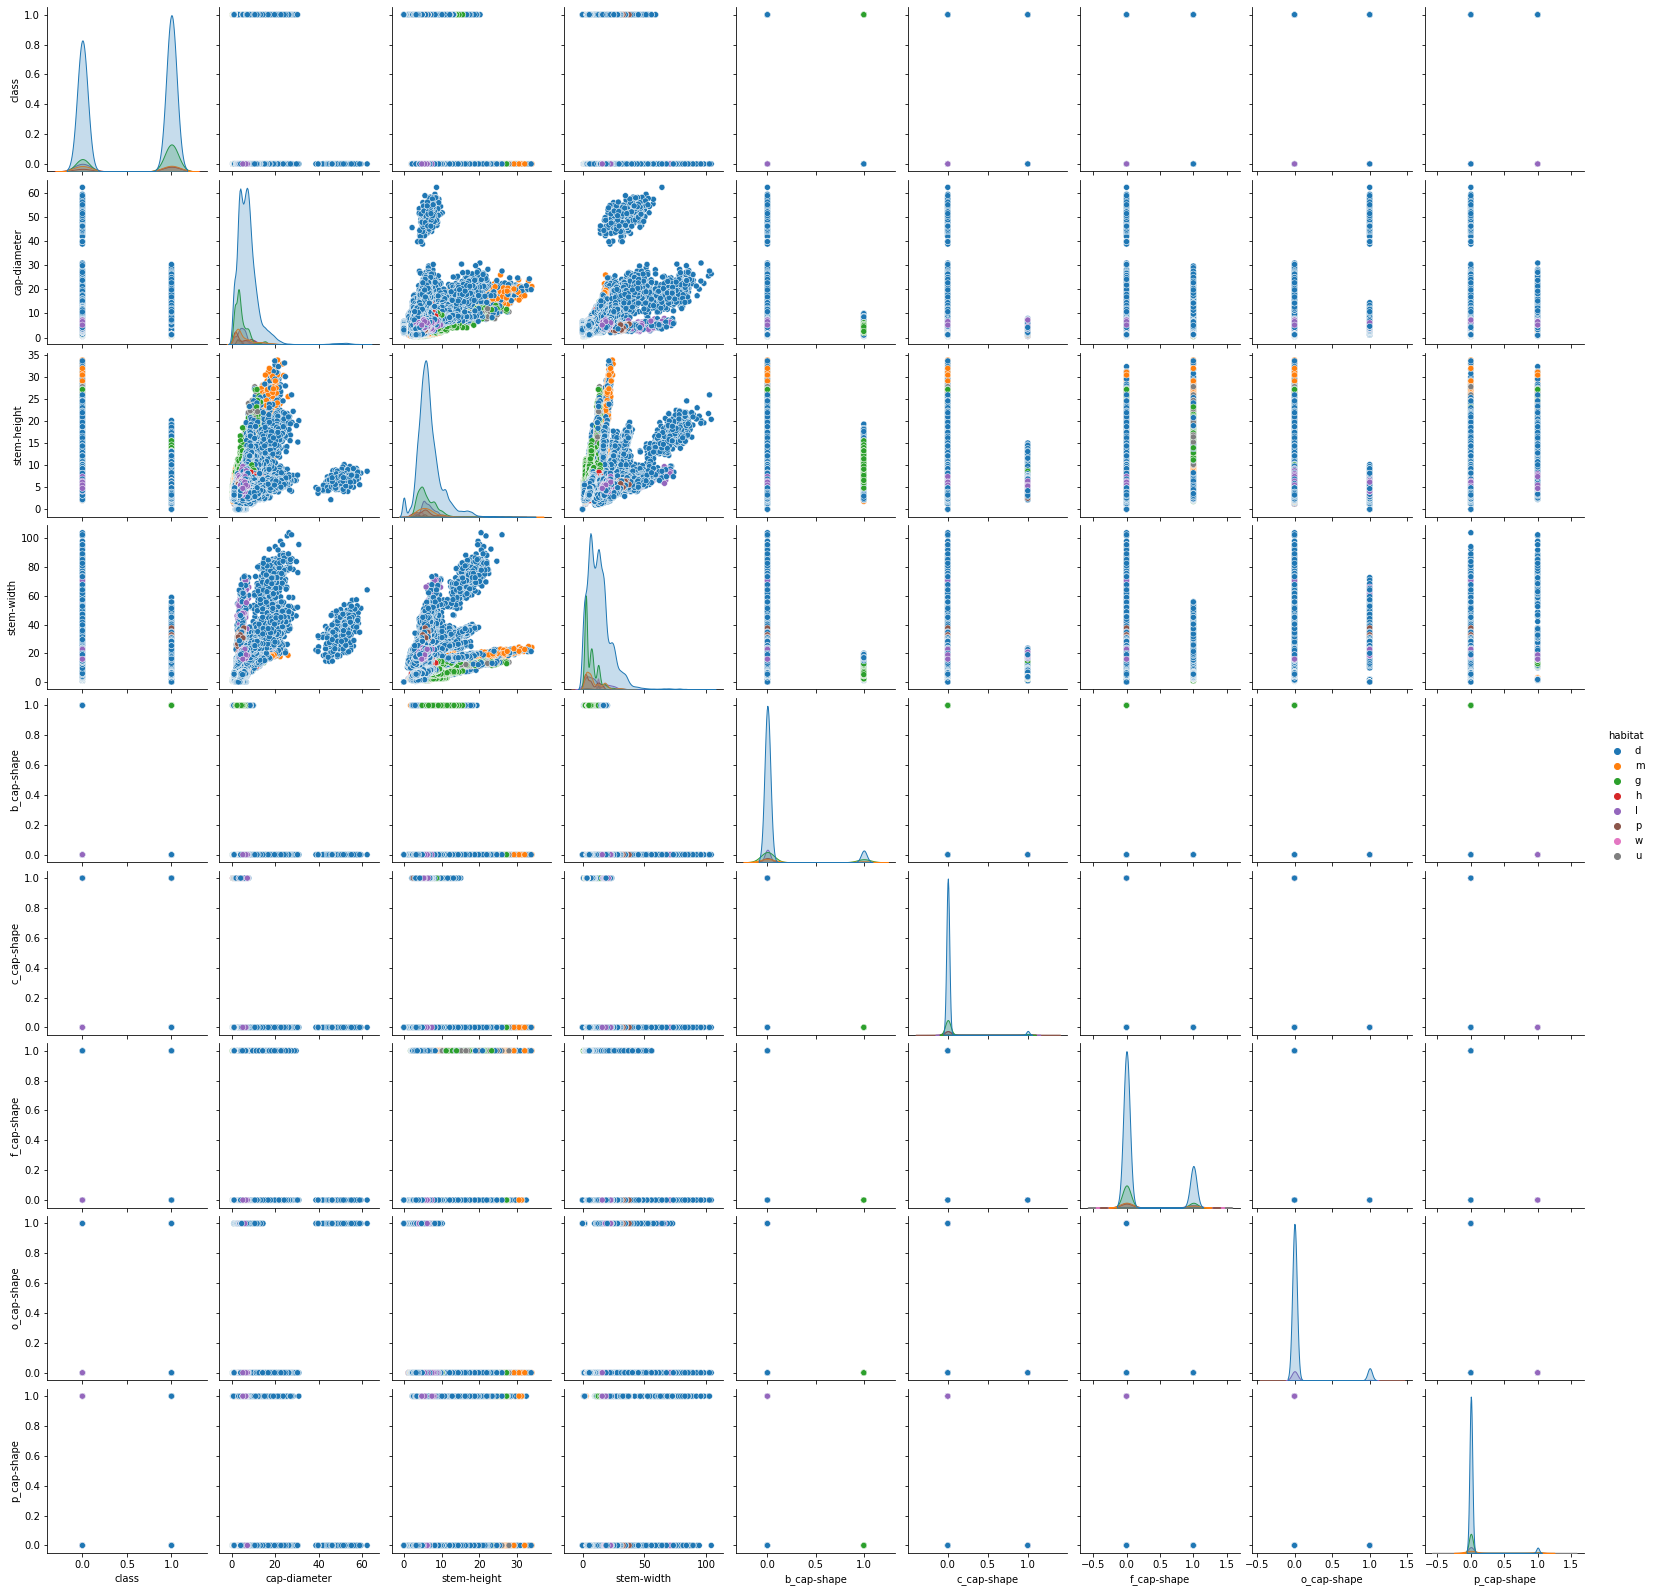

In [37]:
##pairplot by class
sns.pairplot(vis_df, hue='habitat')

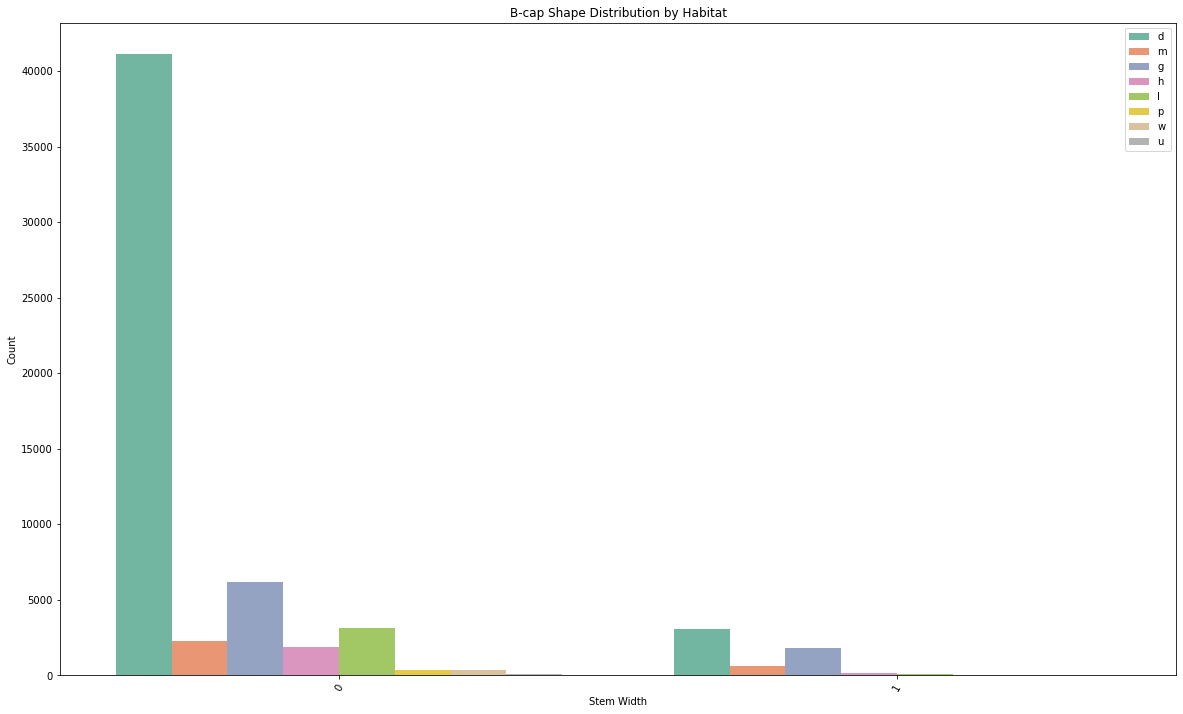

In [58]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['b_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('B-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

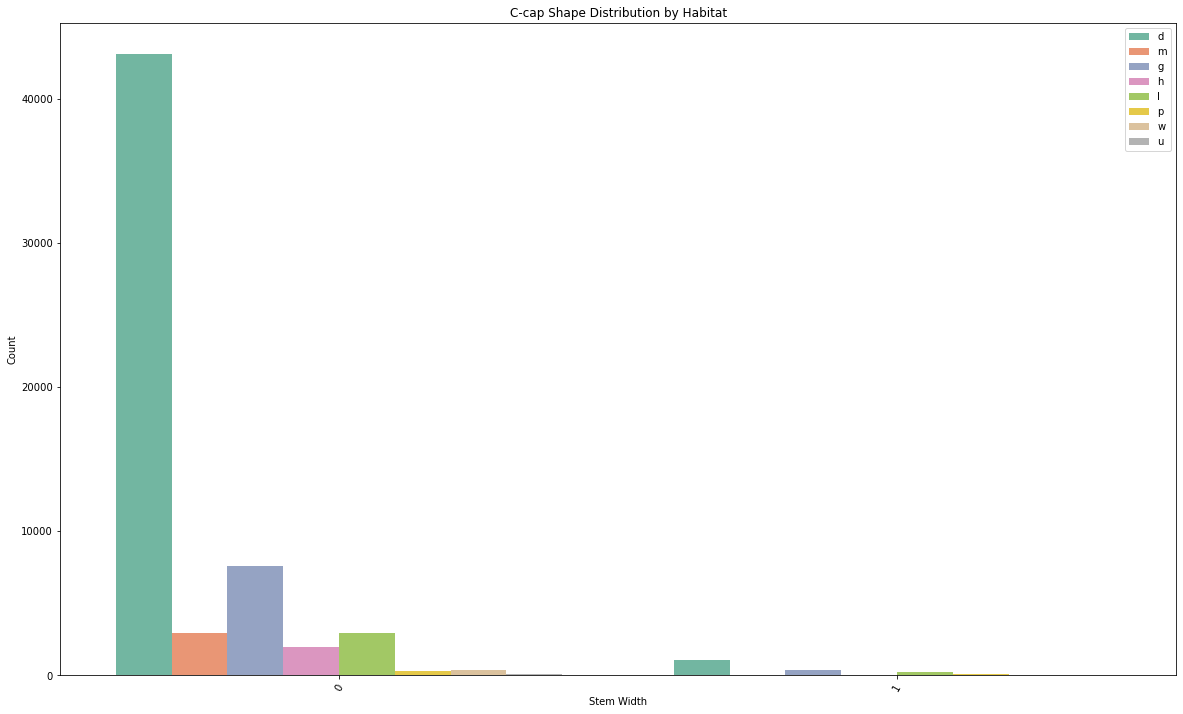

In [59]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['c_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('C-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

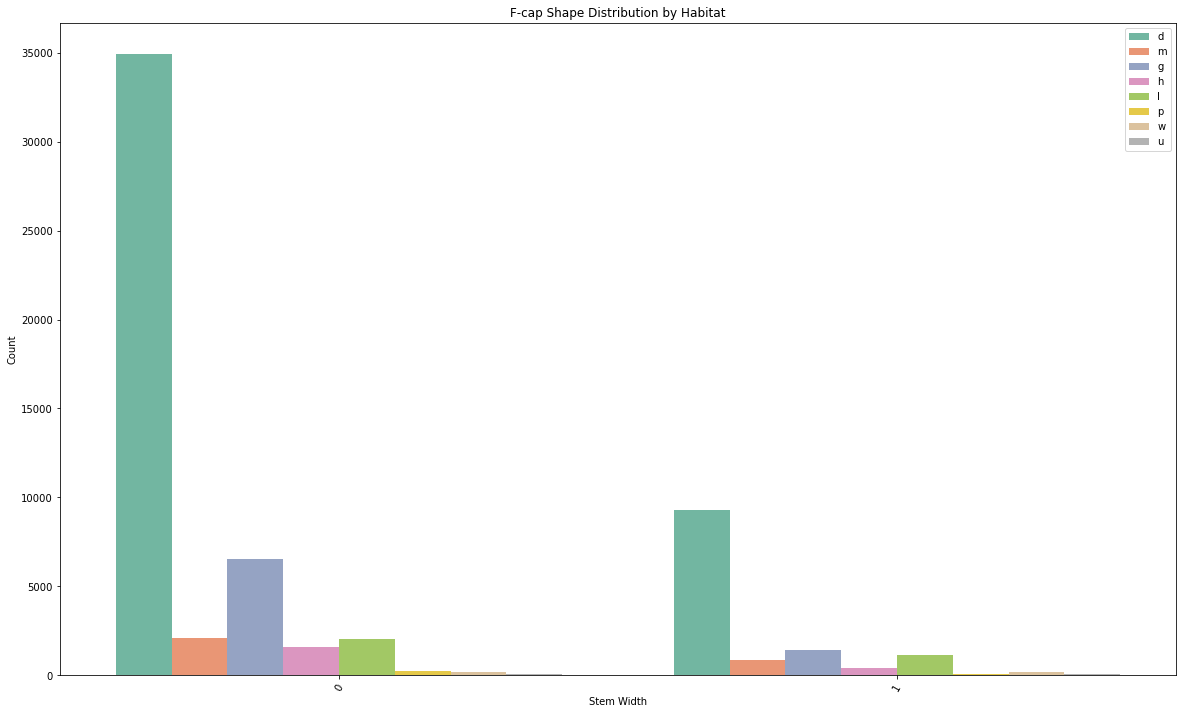

In [60]:
plt.figure(figsize=(20, 12))
sns.countplot(data=vis_df, x=np.array(vis_df['f_cap-shape']), hue=np.array(vis_df['habitat']), palette='Set2')
plt.title('F-cap Shape Distribution by Habitat')
plt.xlabel('Stem Width')
plt.xticks(rotation=60)
plt.ylabel('Count')
plt.show()

   class  cap-diameter  stem-height  stem-width  b_cap-shape  c_cap-shape  \
0      1         15.26        16.95       17.09            0            0   
1      1         16.60        17.99       18.19            0            0   
2      1         14.07        17.80       17.74            0            0   
3      1         14.17        15.77       15.98            0            0   
4      1         14.64        16.53       17.20            0            0   

   f_cap-shape  o_cap-shape  p_cap-shape habitat  
0            0            0            0       d  
1            0            0            0       d  
2            0            0            0       d  
3            1            0            0       d  
4            0            0            0       d  


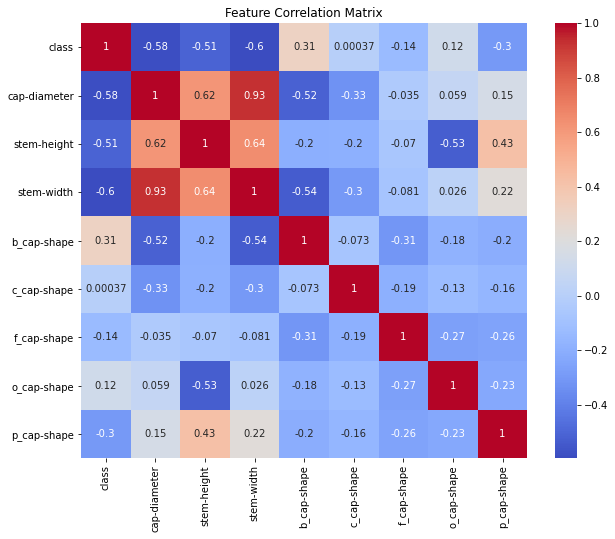

In [69]:
import ast

##creating correlation matrix between relations between all festures to see relation

vis_df_copy = vis_df.copy()

numeric_columns = vis_df_copy.select_dtypes(include=[np.number]).columns
correlation_matrix = vis_df_copy[numeric_columns].corr()

print(vis_df_copy.head())

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()